IMPORTS

In [51]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
import os
import pandas as pd
##from PyPDF2 import PdfReader, PdfMerger
import requests
from scipy import stats, optimize
import zipfile

Key Events

In [52]:
KEY_EVENTS = ['60','100','200','400','60HM50','100HM50','400H','400HM50']

Webscraping - Unique links to Athlete Profiles

In [53]:
url = "https://www.thepowerof10.info/athletes/profile.aspx?athleteid=918535"
df = pd.read_html(url)
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
links = []
for tr in soup.findAll("tr"):
    trs = tr.findAll("td")
    for each in trs:
        try:
            link = each.find('a')['href']
            if 'profile.aspx?athleteid' in link:
                links.append(link)
        except:
            pass
mylist = links
unique_athletes = list(set(mylist))

In [54]:
unique_athletes

['/athletes/profile.aspx?athleteid=1003273',
 '/athletes/profile.aspx?athleteid=719525',
 '/athletes/profile.aspx?athleteid=945252',
 '/athletes/profile.aspx?athleteid=782811',
 '/athletes/profile.aspx?athleteid=465596',
 '/athletes/profile.aspx?athleteid=595915',
 '/athletes/profile.aspx?athleteid=195655',
 '/athletes/profile.aspx?athleteid=964501',
 '/athletes/profile.aspx?athleteid=918535',
 '/athletes/profile.aspx?athleteid=652674',
 '/athletes/profile.aspx?athleteid=652675',
 '/athletes/profile.aspx?athleteid=879985',
 '/athletes/profile.aspx?athleteid=1006692',
 '/athletes/profile.aspx?athleteid=1019307',
 '/athletes/profile.aspx?athleteid=278325']

Visualization of the Athlete's Performances

In [55]:
def plot_event_progression(prediction_dict):
  myFmt = mdates.DateFormatter('%b %y')
  fig = plt.figure(figsize=(6,6))
  # ax = plt.subplot(4,1,count)
  ax = plt.subplot()
  count = 1
  name = prediction_dict['name']
  try:
    ## try to delete old file
    os.remove('{n}.png'.format(n=name))
  except:
    pass
  for event in KEY_EVENTS:
    try:
      df = prediction_dict[event]
    except:
      df = pd.DataFrame()
    if len(df) > 0:
      try:
        ## Merging on an index that has some future dates in it

        # ax.set_title('{e}'.format(e=event))
        ax.set_xlabel('Date')
        ax.set_ylabel('Performance [seconds]')


        color = next(ax._get_lines.prop_cycler)['color']
        ax.scatter(df.index,df['performance'],marker='x',color=color,label=event)
        if df['performance'].count()>2:
          ax.plot(df.index,df['pred'],linestyle='--',color=color)
          ax.fill_between(x=df.index, y1=df['pred']*.97, y2=df['pred']*1.03,alpha=0.1,color=color)

        ax.xaxis.set_major_formatter(myFmt)
        plot_df = df.dropna().tail(1)
        for i, txt in enumerate(plot_df['performance']):
          ax.annotate(txt, (plot_df.index[i], plot_df['performance'][i]+1.),color=color)
        if plot_df['performance'].min() != df['performance'].min():
          ax.annotate(df['performance'].min(),(df['performance'].idxmin(),(df['performance'].min()-1.2)),color=color)
        count += 1
      except Exception as e:
        print('plot_event_progression',event,name,e)
        count += 1
  ax.set_ylim(0)
  ax.legend(loc='lower left')
  mil = MultipleLocator(1)
  mjl = MultipleLocator(5)
  ax.yaxis.set_minor_locator(mil)
  ax.yaxis.set_major_locator(mjl)
  ax.grid(which='minor',alpha=0.3)
  ax.grid(which='major',alpha=0.8)
  fig.suptitle('{n}'.format(n=name),fontsize=20)
  plt.tight_layout()
  fig.subplots_adjust(top=.9)
  fig.savefig('{n}.pdf'.format(n=name))
  plt.close()

Exponential nonlinear regression on input data, generating predictions based on the fitted model.

In [56]:
def model_func(x, A, K,C):
    return A * np.exp(K * x) + C

def fit_exp_nonlinear(x, y):
    opt_parms, parm_cov = optimize.curve_fit(model_func, x, y,bounds=([0,-1e-2,-np.inf], [50.,-1e-9,np.inf]))
    A, K, C = opt_parms
    return A, K, C

def get_predictions(df):
    df2 = pd.DataFrame(index = pd.date_range(start=df.index.min(), end = '2021-12-01',freq='1D'))
    df2 = pd.merge(left=df2, right=df, left_index = True, right_index = True, how='outer')
    df2['day'] = 1.
    df2['day'] = df2['day'].cumsum()
    df = df2.dropna()
    ## creating an x value (unix seconds)
    fit = fit_exp_nonlinear(x=df['day'], y = df['performance'])
    df2['pred'] = model_func(df2['day'], fit[0],fit[1],fit[2])
    return df2

Parse Result Function for Athletics Data

In [57]:
def parse_result(row,athlete):
  result = row[1]
  conditions = row[2]
  event = row[0]
  if event in ['800','1500']:
    result = dt.datetime.strptime(result,'%M:%S.%f')
    result = (result.minute * 60) + float(result.second)
  else:
    if (conditions == 'i') and (event != '60') and (event != '60HM50'):
      return None
    else:
      dict = {}
      dict['date'] =  pd.to_datetime(row[11])
      dict['event'] =  row[0]
      dict['performance'] = float(result)
      dict['athlete'] = str(athlete)
      return dict

Generating List of URLs for Other Athletes

In [58]:
other_athletes = []
for id in ['202737','1117285','330376','175463','551287']:
  other_athletes.append(f"/athletes/profile.aspx?athleteid={id}")

In [59]:
other_athletes

['/athletes/profile.aspx?athleteid=202737',
 '/athletes/profile.aspx?athleteid=1117285',
 '/athletes/profile.aspx?athleteid=330376',
 '/athletes/profile.aspx?athleteid=175463',
 '/athletes/profile.aspx?athleteid=551287']

Collecting and Organizing Athlete Performances

In [60]:
performance_list = []
for athlete in unique_athletes + other_athletes:
  if athlete != '/athletes/profile.aspx?athleteid=918535':
      df = pd.read_html("https://www.thepowerof10.info{}".format(athlete))
      athlete_name = str(df[2][0].item())
      for index, row in df[13].iterrows():
          if row[0] in KEY_EVENTS:
              try:
                  result_dict = parse_result(row,athlete_name)
                  if result_dict is not None:

                    performance_list.append(result_dict)
              except Exception as e:
                  print(e)
  else:
      df = pd.read_html("https://www.thepowerof10.info{}".format(athlete))
      athlete_name = str(df[2][0].item())
      for index, row in df[15].iterrows():
          if row[0] in KEY_EVENTS:
              try:
                  result_dict = parse_result(row,athlete_name)
                  if result_dict is not None:
                    performance_list.append(result_dict)
              except Exception as e:
                  print(e)
performance_df = pd.DataFrame(performance_list)
performance_df.index = performance_df['date']

could not convert string to float: 'DNS'
could not convert string to float: 'DNS'
could not convert string to float: 'TBC'
could not convert string to float: 'DNS'
could not convert string to float: 'DNS'


Creating a List of Unique Athletes

In [61]:
athletes = list(performance_df['athlete'].unique())

Generating Predictions and Event Progression Plots for Individual Athletes

In [62]:
for athlete in athletes:
  try:
    prediction_dict = {}

    prediction_dict['name'] = athlete
    assert athlete not in ['Anna Lipman','Keelan Welch','Lottie Warkcup']

    print(athlete)
    athlete_df = performance_df.loc[performance_df['athlete'] == athlete]
    for event in KEY_EVENTS:
      if len(athlete_df) > 0:
        try:
          event_df = athlete_df.loc[athlete_df['event'] == event,]
          print(event)
          event_df = get_predictions(event_df)
          prediction_dict[event] = event_df
        except Exception as e:
          print(e)
    plot_event_progression(prediction_dict)
  except Exception as e:
    print(e)

James Twallin
60
Neither `start` nor `end` can be NaT
100
200
400
60HM50
Neither `start` nor `end` can be NaT
100HM50
Neither `start` nor `end` can be NaT
400H
Neither `start` nor `end` can be NaT
400HM50
Neither `start` nor `end` can be NaT

Aoife McAuley
60
Neither `start` nor `end` can be NaT
100
200
400
60HM50
Neither `start` nor `end` can be NaT
100HM50
Neither `start` nor `end` can be NaT
400H
Neither `start` nor `end` can be NaT
400HM50
Neither `start` nor `end` can be NaT
Cristina Poulsen
60
100
200
400
Neither `start` nor `end` can be NaT
60HM50
Neither `start` nor `end` can be NaT
100HM50
Neither `start` nor `end` can be NaT
400H
Neither `start` nor `end` can be NaT
400HM50
Neither `start` nor `end` can be NaT
Kieran Shah
60
100
200
400
60HM50
Neither `start` nor `end` can be NaT
100HM50
Neither `start` nor `end` can be NaT
400H
Neither `start` nor `end` can be NaT
400HM50
Neither `start` nor `end` can be NaT
Fraser Kilsby
60
100
200
400
60HM50
Neither `start` nor `end` can b

Reformatting and Sorting Athlete Names

In [63]:
new_list = []
for athlete in athletes:
  athlete = athlete.split(' ')
  dict = {}
  new_list.append(f"{athlete[1]} {athlete[0]}")
new_list.sort()
athletes = new_list

new_list = []
for athlete in athletes:
  athlete = athlete.split(' ')
  dict = {}
  new_list.append(f"{athlete[1]} {athlete[0]}")

athletes = new_list

Creating a Summary of Athlete Performances by Event and Year

In [66]:
row_list = []
for athlete in athletes:

  athlete_df = performance_df.loc[performance_df['athlete'] == athlete]
  for event in KEY_EVENTS:
    event_df = athlete_df.loc[athlete_df['event']== event]
    for year in performance_df.sort_index().index.year.unique()[-2:]:
      year_df = event_df.loc[event_df.index.year == year]

      event_dict = {}
      event_dict['name'] = athlete
      event_dict['event'] = event
      event_dict['year'] = year
      event_dict['SB'] = year_df['performance'].min()
      row_list.append(event_dict)

Creating a DataFrame from Summary Data

In [67]:
df = pd.DataFrame(row_list)

Creating a Pivot Table from DataFrame for Athlete Performances

In [68]:
pivot_df = df.pivot_table(index='name',columns=['event','year'],values= 'SB')

Extracting Years and Event Columns from a Pivot Table

In [69]:
years_cols = []
event_cols = []
for col in pivot_df.columns:
  years_cols.append(col[1])
  event_cols.append(col[0])

Reconstructing a DataFrame with Pivot Table Data

In [70]:
pivot_df = pd.DataFrame(index= pivot_df.index,data = pivot_df.values,columns = years_cols)

Reindexing Pivot Table DataFrame with Athlete Names

In [71]:
pivot_df = pivot_df.reindex(athletes)

Combining Year Information with Pivot Table Data

In [72]:
year_df = pd.DataFrame(columns = years_cols)
year_df.loc['SEASON'] = years_cols
year_df.loc['EVENT'] = event_cols


progress_df = pd.concat([year_df,pivot_df])

Handling Missing Values in the DataFrame

In [73]:
progress_df = progress_df.replace(np.nan,'-')

In [74]:
progress_df

,2022,2023,2022,2023,2022,2023,2022,2023,2023,2022,2023,2022,2023,2022,2023
SEASON,2022,2023,2022,2023,2022,2023,2022,2023,2023,2022,2023,2022,2023,2022,2023
EVENT,100,100,100HM50,100HM50,200,200,400,400,400H,400HM50,400HM50,60,60,60HM50,60HM50
Karen Burles,12.51,-,-,-,25.54,-,-,-,-,-,-,-,8.09,-,-
Ben Gandini,12.0,-,-,-,24.6,-,-,-,-,-,-,-,-,-,-
Fraser Kilsby,11.51,11.88,-,-,-,-,-,53.23,-,-,-,-,7.26,-,-
Raihan Lenoire,-,-,-,-,-,-,50.8,49.9,-,-,-,-,-,-,-
Anna Lipman,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Barrie Marsden,12.98,13.16,14.68,14.82,26.0,26.28,-,-,67.61,65.7,69.15,8.24,-,8.99,9.14
Aoife McAuley,14.0,13.84,-,-,27.5,27.22,66.9,65.8,-,-,-,-,-,-,-
Joshua Parry,11.4,11.19,-,-,22.49,-,-,-,-,-,-,6.96,-,-,-


Creating a Table Visualization and Saving to a PDF

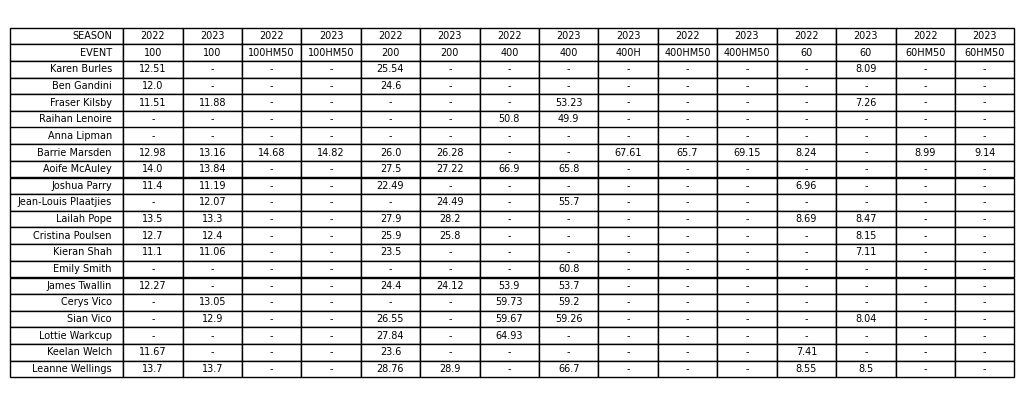

In [76]:
fig, ax =plt.subplots(figsize=(11.5,5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=progress_df.values,rowLabels=progress_df.index,loc='center',cellLoc='center',rowLoc='right')
table.auto_set_font_size(False)
table.set_fontsize(7)
# table.scale(0.5, 0.5)
pp = PdfPages("table.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()